<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/Colab_timeseries_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - timeseries package for fastai v2

In [ ]:
!pip install git+https://github.com/fastai/fastai2.git

In [ ]:
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

In [ ]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [ ]:
# url = 'http://www.timeseriesclassification.com/Downloads/NATOPS.zip'
path = unzip_data(URLs_TS.NATOPS)
path

Path('C:/Users/fh/.fastai/data/NATOPS')

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_TRAIN.arff'),
 Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_TRAIN', 'NATOPS_TEST']
 Filenames:                     [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_TRAIN.arff'), Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_TEST.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels:           24
 Sequence Length: 51


In [ ]:
items = data.get_items()

In [ ]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

In [ ]:
bs = 128                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

In [ ]:
default_device()

In [ ]:
dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms, num_workers=0, device=default_device())

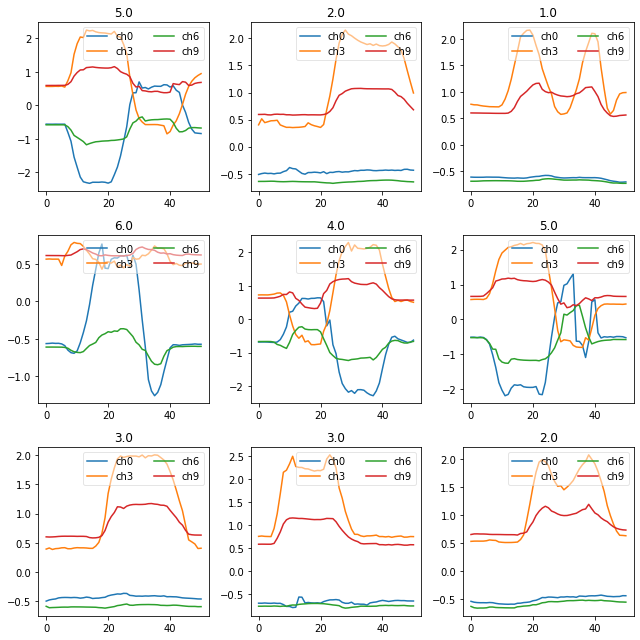

In [ ]:
dls.show_batch(max_n=9, chs=range(0,12,3))

# Train Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(24, 6)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(24, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39

In [ ]:
#Learner
opt_func = partial(Adam, lr=3e-3, wd=0.01)     
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 24 x 51'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 51         29,952     True      
________________________________________________________________
Conv1d               64 x 32 x 51         14,592     True      
________________________________________________________________
Conv1d               64 x 32 x 51         6,912      True      
________________________________________________________________
MaxPool1d            64 x 24 x 51         0          False     
________________________________________________________________
Conv1d               64 x 32 x 51         768        True      
________________________________________________________________
BatchNorm1d          64 x 128 x 51        256        True      
________________________________________________________________
ReLU                 64 x 128 x 51        0          False     
_______________________________________________________

(0.014454397559165954, 0.00013182566908653826)

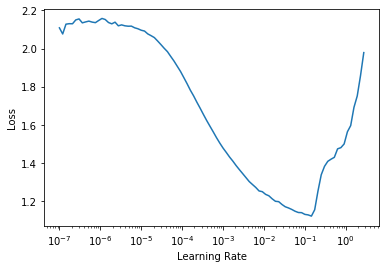

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
#lr_max=1e-3
epochs=30; lr_max=lr_steep;  pct_start=.7; moms=(0.95,0.85,0.95); wd=1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
# learn.fit_one_cycle(epochs, lr_max=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,2.069652,1.791920,0.125000,00:02
1,2.052434,1.794972,0.194444,00:01
2,2.008281,1.799823,0.194444,00:02
3,1.944215,1.806062,0.194444,00:01
4,1.869186,1.812944,0.194444,00:01
5,1.782324,1.819286,0.194444,00:01
6,1.689418,1.812420,0.277778,00:02
7,1.590454,1.755855,0.305556,00:01
8,1.496907,1.611264,0.458333,00:01
9,1.405312,1.366859,0.763889,00:02


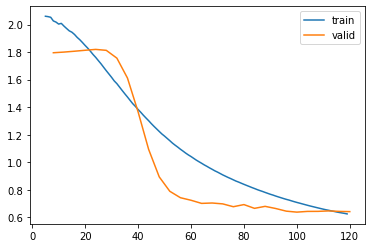

In [ ]:
learn.recorder.plot_loss()

<img src="https://github.com/ai-fast-track/timeseries/blob/master/images/nature-red-forest-leaves.jpg?raw=1" width="1440" height="840" alt=""/>